In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
from data_cleaning import load_and_prepare, merge_and_aggregate
from scipy.stats.mstats import winsorize
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

/Users/guziyi/Desktop/htsc/gold_pairstrading/code/pair_utils.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_static = model.params[1]


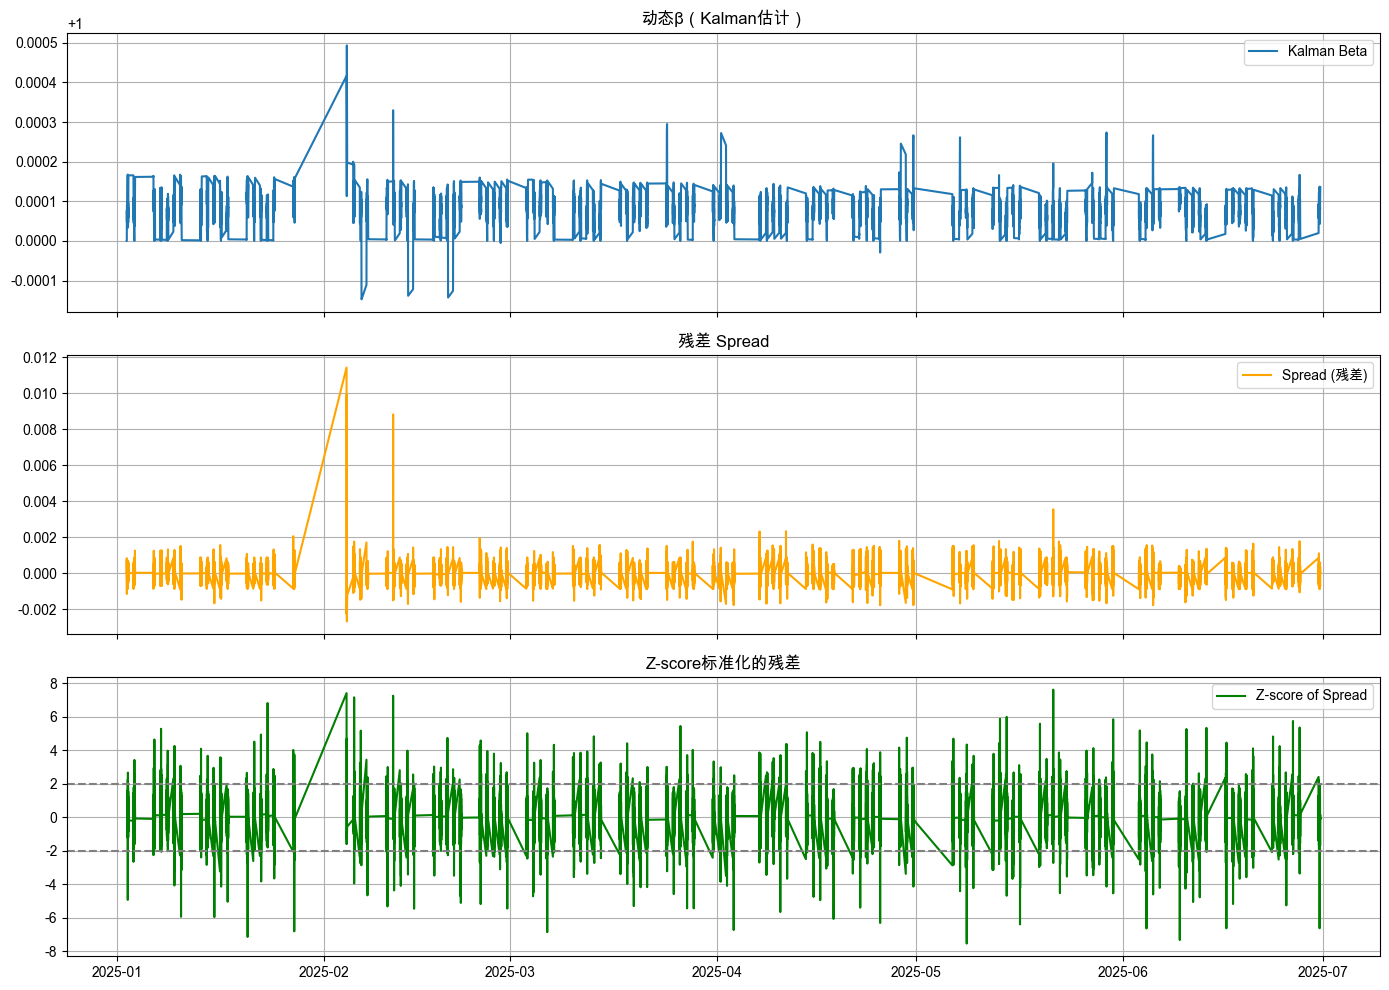

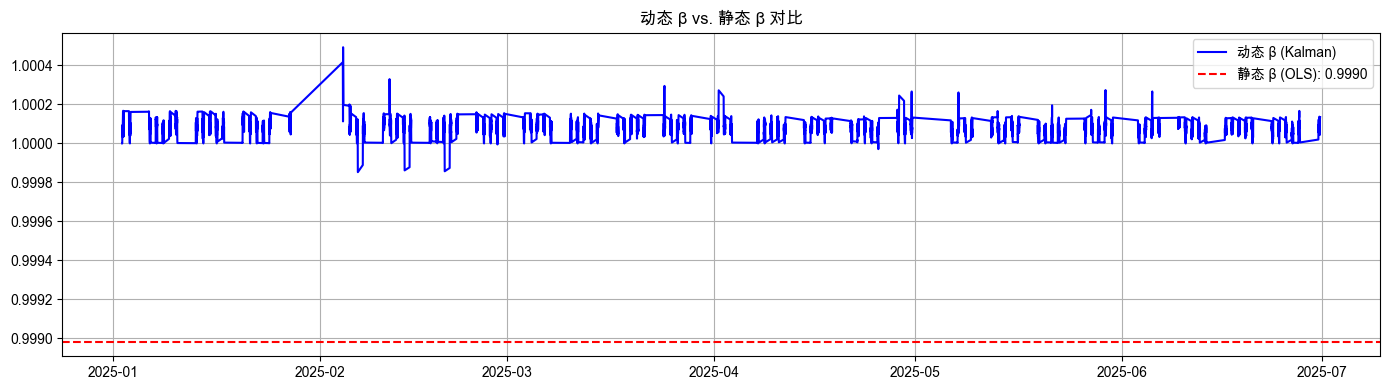

In [1]:
from pairs_kalman import combine_md_datetime,load_and_prepare,merge_and_aggregate,kalman_and_cointegration


etf_path = "../data/518880.SH_20250101_20250630.csv"
au_path = "../data/AU99.99.SGE_20250101_20250630.csv"

etf_df = load_and_prepare(etf_path, prefix='ETF')
au_df = load_and_prepare(au_path, prefix='AU')

merged_agg = merge_and_aggregate(etf_df, au_df, group_size=30)

result = kalman_and_cointegration(merged_agg, win=60)

下面是原来的代码，已经封装

In [ ]:
def kalman_and_cointegration(df, col_y , col_x, win=60):
    state_mean = INIT_MEAN
    state_var = INIT_VAR
    betas = []
    spreads = []

    for i in range(len(df)):
        py = df.loc[i, col_y]
        px = df.loc[i, col_x]

        pred_mean = state_mean
        pred_var = state_var + STATE_VAR
        k_gain = pred_var / (pred_var * px**2 + OBS_VAR)
        state_mean = pred_mean + k_gain * (py - pred_mean * px)
        state_var = (1 - k_gain * px) * pred_var

        beta = state_mean
        spread = py - beta * px

        betas.append(beta)
        spreads.append(spread)

    df['beta_kalman'] = betas
    df['spread'] = spreads
    df['spread_mean'] = pd.Series(spreads).rolling(win).mean()
    df['spread_std'] = pd.Series(spreads).rolling(win).std()
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    # === 可视化 ===
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axes[0].plot(df['DateTime'], df['beta_kalman'], label='Kalman Beta')
    axes[0].set_title("动态β（Kalman估计）")
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(df['DateTime'], df['spread'], label='Spread (残差)', color='orange')
    axes[1].set_title("残差 Spread")
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(df['DateTime'], df['zscore'], label='Z-score of Spread', color='green')
    axes[2].axhline(2, linestyle='--', color='gray')
    axes[2].axhline(-2, linestyle='--', color='gray')
    axes[2].set_title("Z-score标准化的残差")
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()
    plt.show()
    
    return df[['DateTime', col_y, col_x, 'beta_kalman', 'spread', 'zscore']], test_result
    